In [1]:
# This is a simple tool for pre-processing tweets in large tweet databases.
import re
import string
from sklearn.neighbors import LSHForest
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

class singleTweet:
    """Allows basic operations to be performed on a single tweet. Must import
    regex for this to work properly.
    
                ------------------------------------------------
    Methods:
    
    .tweet               Returns the tweet as a string.
    .strip_non_ascii()   Strips non-ascii characters from the tweet string.
    .strip_punctuation   Strips punctuation. If strip_hashtags is set to False,
                         then it does NOT strip hashtags. Otherwise, strips them.
    .utf8                Converts the tweet to utf-8 if possible.
    .urls                The regex used to match urls. Modify as needed.
    .strip_links()       Strips links by using regex to sub out any words that
                         contain 'http' or any of a number of suffixes contained
                         in self.urls
    .lowercase           Converts tweet to all lowercase."""
    
    def __init__(self, tweet):
        self.tweet = tweet
        pass

    def strip_non_ascii(self):
        """Replaces all non-ascii characters in the tweet with a space. Returns
        tweet."""

        return ''.join([i if ord(i) < 128 else ' ' for i in self.tweet])

    punctuation = re.compile('[%s]' % re.escape(string.punctuation))
    punctuation_sans_hashtags = re.compile('[%s]' % 
                                           re.escape(string.punctuation.replace('#', '')))

    def strip_punctuation(self, strip_hashtags = True):
        """Removes punctuation. If strip_hashtags = True, then also removes 
        hashtags. Returns tweet."""

        if strip_hashtags:
            self.tweet = self.punctuation.sub('', self.tweet)
        else:
            self.tweet = self.punctuation_sans_hashtags.sub('', self.tweet)

    def utf8(self):
        """Converts tweet to utf-8 encoding, if possible."""

        self.tweet = unicode(self.tweet, "utf-8")

    urls = re.compile(r"""(http\S+ ?)|(\S+\.com?\S+ ?)|(\S+\.ly?\S+ ?)|(\S+\.net?\S+ ?)|(\S+\.gov?\S+ ?)|(\S+\.edu?\S+ ?)|(\S+\.org?\S+ ?)""")

    def strip_links(self):
        """Uses regex to remove anything that looks like a link in the tweet.
        Identifies text that looks like a tweet using URL suffixes."""

        self.tweet = self.urls.sub('', self.tweet)

    def lowercase(self):
        """Converts tweet to all lowercase characters."""

        self.tweet = self.tweet.lower()

    def strip_and_lower(self):
        """Performs all stripping functions (including stripping non-ascii chars)
        and lowercases the tweet. Does NOT convert it to utf-8."""

        self.strip_non_ascii()
        self.strip_links()
        self.lowercase()
        self.strip_punctuation()


class tweetDatabase:
    """Takes a list of tweets as input and does operations on the entire list
    all at once."""

    def __init__(self, tweets):
        self.tweets = tweets

    def strip_and_lower(self):
        for tweet in range(len(self.tweets)):
            t = singleTweet(self.tweets[tweet])
            t.strip_and_lower()
            self.tweets[tweet] = t.tweet

    def identify_spam(self):
        """Cluster tweets and throw out nearly-identical ones. Gets rid both
        of spam tweets and of unofficial retweets."""

# Pull some tweets from my mongo database. Note: tweets that are being pulled are all from the same 1-week period.
from pymongo import MongoClient
client = MongoClient()
db = client.tweets
collect = db.test_collection #change this be the right collection!

tweets = collect.find({'computer_classified' : 1})

tweet_db_main = []
ind = 0
for t in tweets:
    ind +=1
    if ind == 150000: break
    tweet_db_main.append(t['text'])

tweets = tweetDatabase(tweet_db_main)
tweets.strip_and_lower()
tweet_db_main = tweets.tweets

# Try different batch sizes to find out how many tweets to cluster at a time:
import time, numpy as np
import random

def tweets_batch_maker(all_tweets, batch_size):
    random.shuffle(all_tweets)
    tweets_to_return = []
    for t in range(batch_size):
        tweets_to_return.append(all_tweets[t])
    return tweets_to_return

def single_batch(tweet_db):

    # Vectorize and fit tree:
    timer = time.time()
    vect2 = TfidfVectorizer()
    X2 = vect2.fit_transform(tweet_db)
    tree2 = LSHForest()
    tree2.fit(X2)
    print "that took %2f seconds" % (time.time()-timer)

    # Build tree:
    timer = time.time()
    n_neighbors = []
    neighbors_indices = []
    for x in vect2.transform(tweet_db):
        if len(n_neighbors) % 100 == 0: print len(n_neighbors)
        neighbors = tree2.radius_neighbors(x, radius = .3)[1]
        n_neighbors.append(len(neighbors[0]))
        neighbors_indices.append(neighbors)
    tree_build_time = (time.time() - timer)

    # Find neighbors:
    l = list(n_neighbors)
    l = [l.index(x) for x in l if x > 1]
    # Get indices of the tweets that are parts of close clusters:
    len_l = len(set(l))
    actual_neighbors =[]
    for x in set(l):
        for neigh in neighbors_indices[x][0]:
            actual_neighbors.append(tweet_db[neigh])

    return np.mean(n_neighbors), actual_neighbors, len_l, tree_build_time

mean_neighbor_counts = []
cluster_counts = []
build_times = []
neighb_counts = []
for x in [10000, 20000, 30000]:
    tweets_db = tweets_batch_maker(tweet_db_main, x)
    mean_neighbor_count, neighbs, cluster_count, build_time = single_batch(tweets_db)
    mean_neighbor_counts.append(mean_neighbor_count)
    cluster_counts.append(cluster_count)
    build_times.append(build_time)
    neighb_counts.append(len(neighbs))



that took 0.212876 seconds
0
100
200
300
400
500
600
700
800
900
that took 1.386297 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
that took 0.490556 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
that took 0.648001 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
that took 0.814566 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
that took 0.892851 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


IndexError: list index out of range

In [25]:
# Convert the numbers outputted above into numbers for interesting plots:
batch_sizes = np.array([1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000., 9000.])
mean_neighbor_counts = np.array(mean_neighbor_counts)
cluster_counts = np.array(cluster_counts) # Represents how many types of spam
build_times = np.array(build_times)
neighb_counts = np.array(neighb_counts) # Total number of spam pieces

seconds_per_tweet = build_times/batch_sizes # Plot against batch_sizes
percent_spam = neighb_counts/batch_sizes # Plot against batch_sizes


[ 0.014       0.047       0.04166667  0.0635      0.0836      0.08516667
  0.10242857  0.077375    0.10111111]


In [9]:
# Write a sample of spam tweets to a file:
def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

with open('spam_sample.txt', 'w') as outfile:
    for x in neighbs:
        x = remove_non_ascii(x)
        outfile.write(x + '\n')

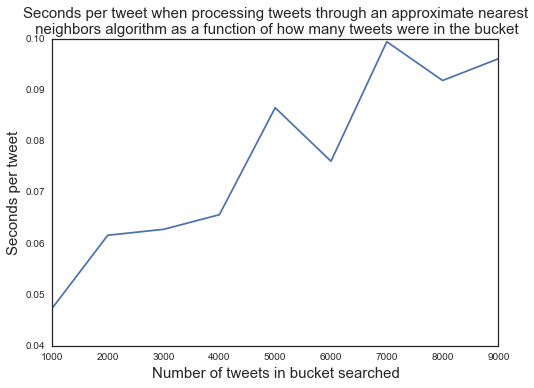

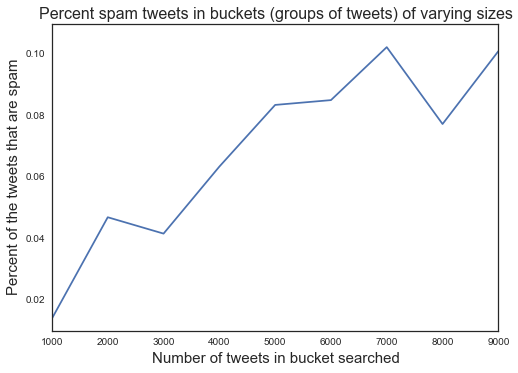

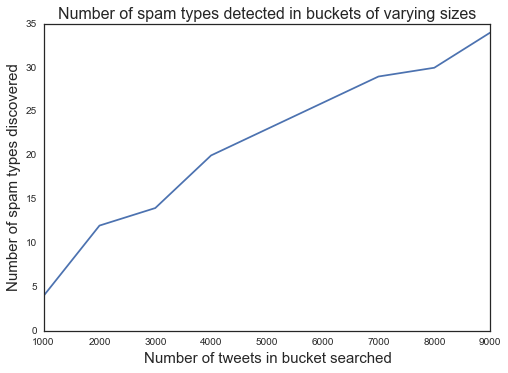

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'white')

plt.plot(batch_sizes, seconds_per_tweet)
plt.title("Seconds per tweet when processing tweets through an approximate nearest\n neighbors algorithm as a function of how many tweets were in the bucket", fontsize = 15)
plt.xlabel("Number of tweets in bucket searched", fontsize = 15)
plt.ylabel("Seconds per tweet", fontsize = 15)
plt.savefig("fig1.pdf")
plt.show()

plt.plot(batch_sizes, percent_spam)
plt.title("Percent spam tweets in buckets (groups of tweets) of varying sizes", fontsize = 16)
plt.xlabel("Number of tweets in bucket searched", fontsize = 15)
plt.ylabel("Percent of the tweets that are spam", fontsize = 15)
plt.savefig("fig2.pdf")
plt.show()

plt.plot(batch_sizes, cluster_counts)
plt.title("Number of spam types detected in buckets of varying sizes", fontsize = 16)
plt.xlabel("Number of tweets in bucket searched", fontsize = 15)
plt.ylabel("Number of spam types discovered", fontsize = 15)
plt.savefig("fig3.pdf")
plt.show()